In [ ]:
import os
import glob
import random

import torch
import torchvision
import numpy as np
import cv2
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
import torch.nn.functional as F

from IPython.display import Image

Подключаем cuda

In [ ]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

device

'cuda'

## Датасет

Ссылка на датасет - https://www.kaggle.com/datasets/lantian773030/pokemonclassification

Датасет состоит из изображений покемонов, разделенных на классы.

Всего 150 классов.

Изображения изначально разных размеров, приведем изображения к одному размеру 100 на 100 пикселей

In [ ]:
import os
import glob
import matplotlib.pyplot as plt

In [ ]:
DATA_PATH = r'C:\edu\2\NT\PokemonData'
classes = {n: cls for n,cls in enumerate(os.listdir(DATA_PATH))}
classes_invert = {value:key for key, value in classes.items() }

class PokemonDataset(Dataset):

    def __init__(self, rootdir, transform) -> None:
        super().__init__()
        self.class_names = os.listdir(rootdir)
        self.class_idx = [i for i in range(len(self.class_names))]
        self.transform = transform
        self.images_pathes = []
        self.images_clas_names = []

        for cls_name in self.class_names:
            sub_root = os.path.join(rootdir, cls_name)
            self.images_pathes.extend(glob.glob(os.path.join(sub_root, '*.jpg')))
            self.images_clas_names.append(cls_name)

        random.shuffle(self.images_pathes)

    def __len__(self):
        return len(self.images_pathes)

    def __getitem__(self, index) -> tuple:

        img_path = self.images_pathes[index]
        image = cv2.imread(img_path)
        img_folder_pth = os.path.split(img_path)[0]
        cls_name = os.path.split(img_folder_pth)[-1]
        label = self.class_names.index(cls_name)

        if self.transform:
            image = self.transform(image)

        return (image, label)

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.5, std = 0.5)
    ]
)

In [ ]:
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

Оригинальный датасет не разделен на тренировочную и тестовую выборки, поэтому разделим датасет в соотношении 80 на 20

In [ ]:
TEST_SIZE = 0.2
BATCH_SIZE = 64
SEED = 42

In [ ]:
dataset = PokemonDataset(DATA_PATH, transform)

In [ ]:
generator = torch.Generator().manual_seed(SEED)

train_dataset, test_dataset = random_split(dataset, [1-TEST_SIZE, TEST_SIZE], generator=generator)

In [ ]:
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
for x,y in train_loader:
    print(x.shape)
    print(y)
    break


torch.Size([64, 3, 200, 200])
tensor([117,  33,  54,  80,  59,  10, 145,  47,  41, 104,  23,  82, 135, 135,
        129,   5,  79, 117,  36, 108,  51, 104, 138, 141,  89,  55,  24,  98,
        123, 144, 105, 111,  61, 149,  45,  61,  70, 112, 133,  23,  47,  69,
        127,  39, 102, 114, 117,  14, 138,  46,  52,  85,  83,  65,  61,  92,
        111,  36,   6,  81, 145,  55,  29,  29])


## Модель

In [ ]:
# выход с последнего слоя
print(f"Кол-во классов: {len(classes.values())}")

Кол-во классов: 150


In [ ]:
print(229//2)

114


Имеем входной тензор 200 на 200.

Вычисляем кол-во нейронов на полносвязном слое.

(200 - 3 + 1) // 2 = 99

(99 - 3 + 1) // 2 = 48

(48 - 3 + 1) // 2 = 23

32 * 23 * 23 = 16928

In [ ]:
class PokemonClassificator(nn.Module):
    def __init__(self):
        super(PokemonClassificator, self).__init__()
        self.conv_1 = nn.Conv2d(3, 8, (3,3), 1)
        self.avPoll_1 = nn.AvgPool2d((2,2), 2)
        self.conv_2 = nn.Conv2d(8, 16, (3,3), 1)
        self.avPoll_2 = nn.AvgPool2d((2,2), 2)
        self.conv_3 = nn.Conv2d(16, 32, (3,3), 1)
        self.avPoll_3 = nn.AvgPool2d((2,2), 2)
        self.linear_1 = nn.Linear(16928, 1024)
        self.linear_2 = nn.Linear(1024, 150)


    def forward(self, x):
        x = self.conv_1(x)
        x = F.tanh(x)
        x = self.avPoll_1(x)
        x = F.tanh(x)

        x = self.conv_2(x)
        x = F.tanh(x)
        x = self.avPoll_2(x)
        x = F.tanh(x)

        x = self.conv_3(x)
        x = F.tanh(x)
        x = self.avPoll_3(x)
        x = F.tanh(x)

        x = torch.flatten(x, start_dim=1)

        x = self.linear_1(x)
        x = F.tanh(x)
        x = self.linear_2(x)

        return x

In [ ]:
model = PokemonClassificator()
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()

optimizator = torch.optim.Adam(model.parameters(), lr=0.001,)

In [ ]:
def val(model, test_loader):
    model.eval()
    tp = 0
    total = 0

    for x,y in test_loader:
        y = y.to(device)
        pred = torch.argmax(model(x.to(device)), dim=1)
        tp += int((pred == y).sum().to('cpu'))
        total +=len(pred)

    return tp/total

def train(dataloader, model, loss_fn, op_fn, epoch):
    acc = 0
    for ep in range(epoch):
        for step, (x, y) in enumerate(dataloader):


            y_pred = model(x.to(device))
            loss = loss_fn(y_pred.to(device), y.to(device))

            op_fn.zero_grad()
            loss.backward()
            op_fn.step()

            if step%100 == 0:
                loss, current = loss.item(), (ep+1)*(step+1)*BATCH_SIZE
                print(f"loss = {loss}, samples = {current}")

        acc = val(model, test_loader)
        print('precision =', acc)


    return acc


In [ ]:
accuracy = train(train_loader, model, loss_function, optimizator, 5)

loss = 5.0115203857421875, samples = 64
loss = 2.466407537460327, samples = 6464
precision = 0.45379413974455296
loss = 2.0808708667755127, samples = 128
loss = 1.5402053594589233, samples = 12928
precision = 0.6611570247933884
loss = 1.4293529987335205, samples = 192
loss = 1.109795093536377, samples = 19392
precision = 0.7926371149511645
loss = 0.8755098581314087, samples = 256
loss = 0.5849250555038452, samples = 25856
precision = 0.8700225394440271
loss = 0.48679766058921814, samples = 320
loss = 0.4290734529495239, samples = 32320
precision = 0.9233658903080391


Сохраним модель, указав датасет, кол-во эпох и точность

In [ ]:
accuracy = (accuracy*100)
output_str = f"pokemon_200_classifier_5_{accuracy:.2f}"
output_str = output_str.replace(".", "_")
output_str = output_str + '.pt'
print(output_str)

pokemon_200_classifier_5_92_34.pt


In [ ]:
torch.save(model, output_str)

## Оценка модели

In [ ]:
model.to('cpu')
model(x).size()

torch.Size([64, 150])

In [ ]:
model.eval()

PokemonClassificator(
  (conv_1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (avPoll_1): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv_2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (avPoll_2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv_3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (avPoll_3): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (linear_1): Linear(in_features=16928, out_features=1024, bias=True)
  (linear_2): Linear(in_features=1024, out_features=150, bias=True)
)

In [ ]:
predicts = []
labels = []

for x,y in test_loader:
    y = y.to('cpu').numpy()
    pred = torch.argmax(model(x.to('cpu')), dim=1).to('cpu').numpy()
    predicts.append(pred)
    labels.append(y)

print(len(predicts))


21


Посмотрим ответы модели

С помощью num_in_batch выбираем картинку в первом batch

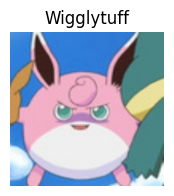

Истинная метка: 147 - Wigglytuff
Предсказ метка: 147 - Wigglytuff


In [ ]:
num_in_batch = 1
for x,y in test_loader:
    # Преобразование значений изображения из диапазона [-1, 1] в диапазон [0, 1]
    img = (x[num_in_batch].numpy().transpose(1, 2, 0) + 1) / 2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    # Преобразование значений изображения из диапазона [0, 1] в диапазон [0, 255] (Перемешались цвет. каналы)
    plt.imshow((img*255).astype('int32'))
    plt.title(classes[int(y[num_in_batch])])
    plt.show()
    print(f'Истинная метка: {y[num_in_batch].numpy()} - {classes[int(y[num_in_batch])]}')
    print(f'Предсказ метка: {predicts[0][num_in_batch]} - {classes[int(predicts[0][num_in_batch])]}')
    break

In [ ]:
predicts = np.concatenate(predicts)
labels = np.concatenate(labels)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

Посчитаем метрики: Accuracy, Precision, recall. Посчитаем для каждого класса в бинарном виде каждую метрику и возьмём среднее.

In [ ]:
print(f"Accuracy = {accuracy_score(labels, predicts)}",
    f"\nPrecision = {precision_score(labels, predicts, average=None, zero_division=0).mean()}",
    f"\nRecall = {recall_score(labels, predicts, average=None).mean()}")

Accuracy = 0.9233658903080391 
Precision = 0.9334479670656142 
Recall = 0.9279691512191512


In [ ]:
cm = confusion_matrix(labels, predicts, labels=tuple(classes.keys()))

In [ ]:
cm.shape

(150, 150)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          font_size = 14):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(60, 40))
    plt.rcParams.update({'font.size': font_size})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

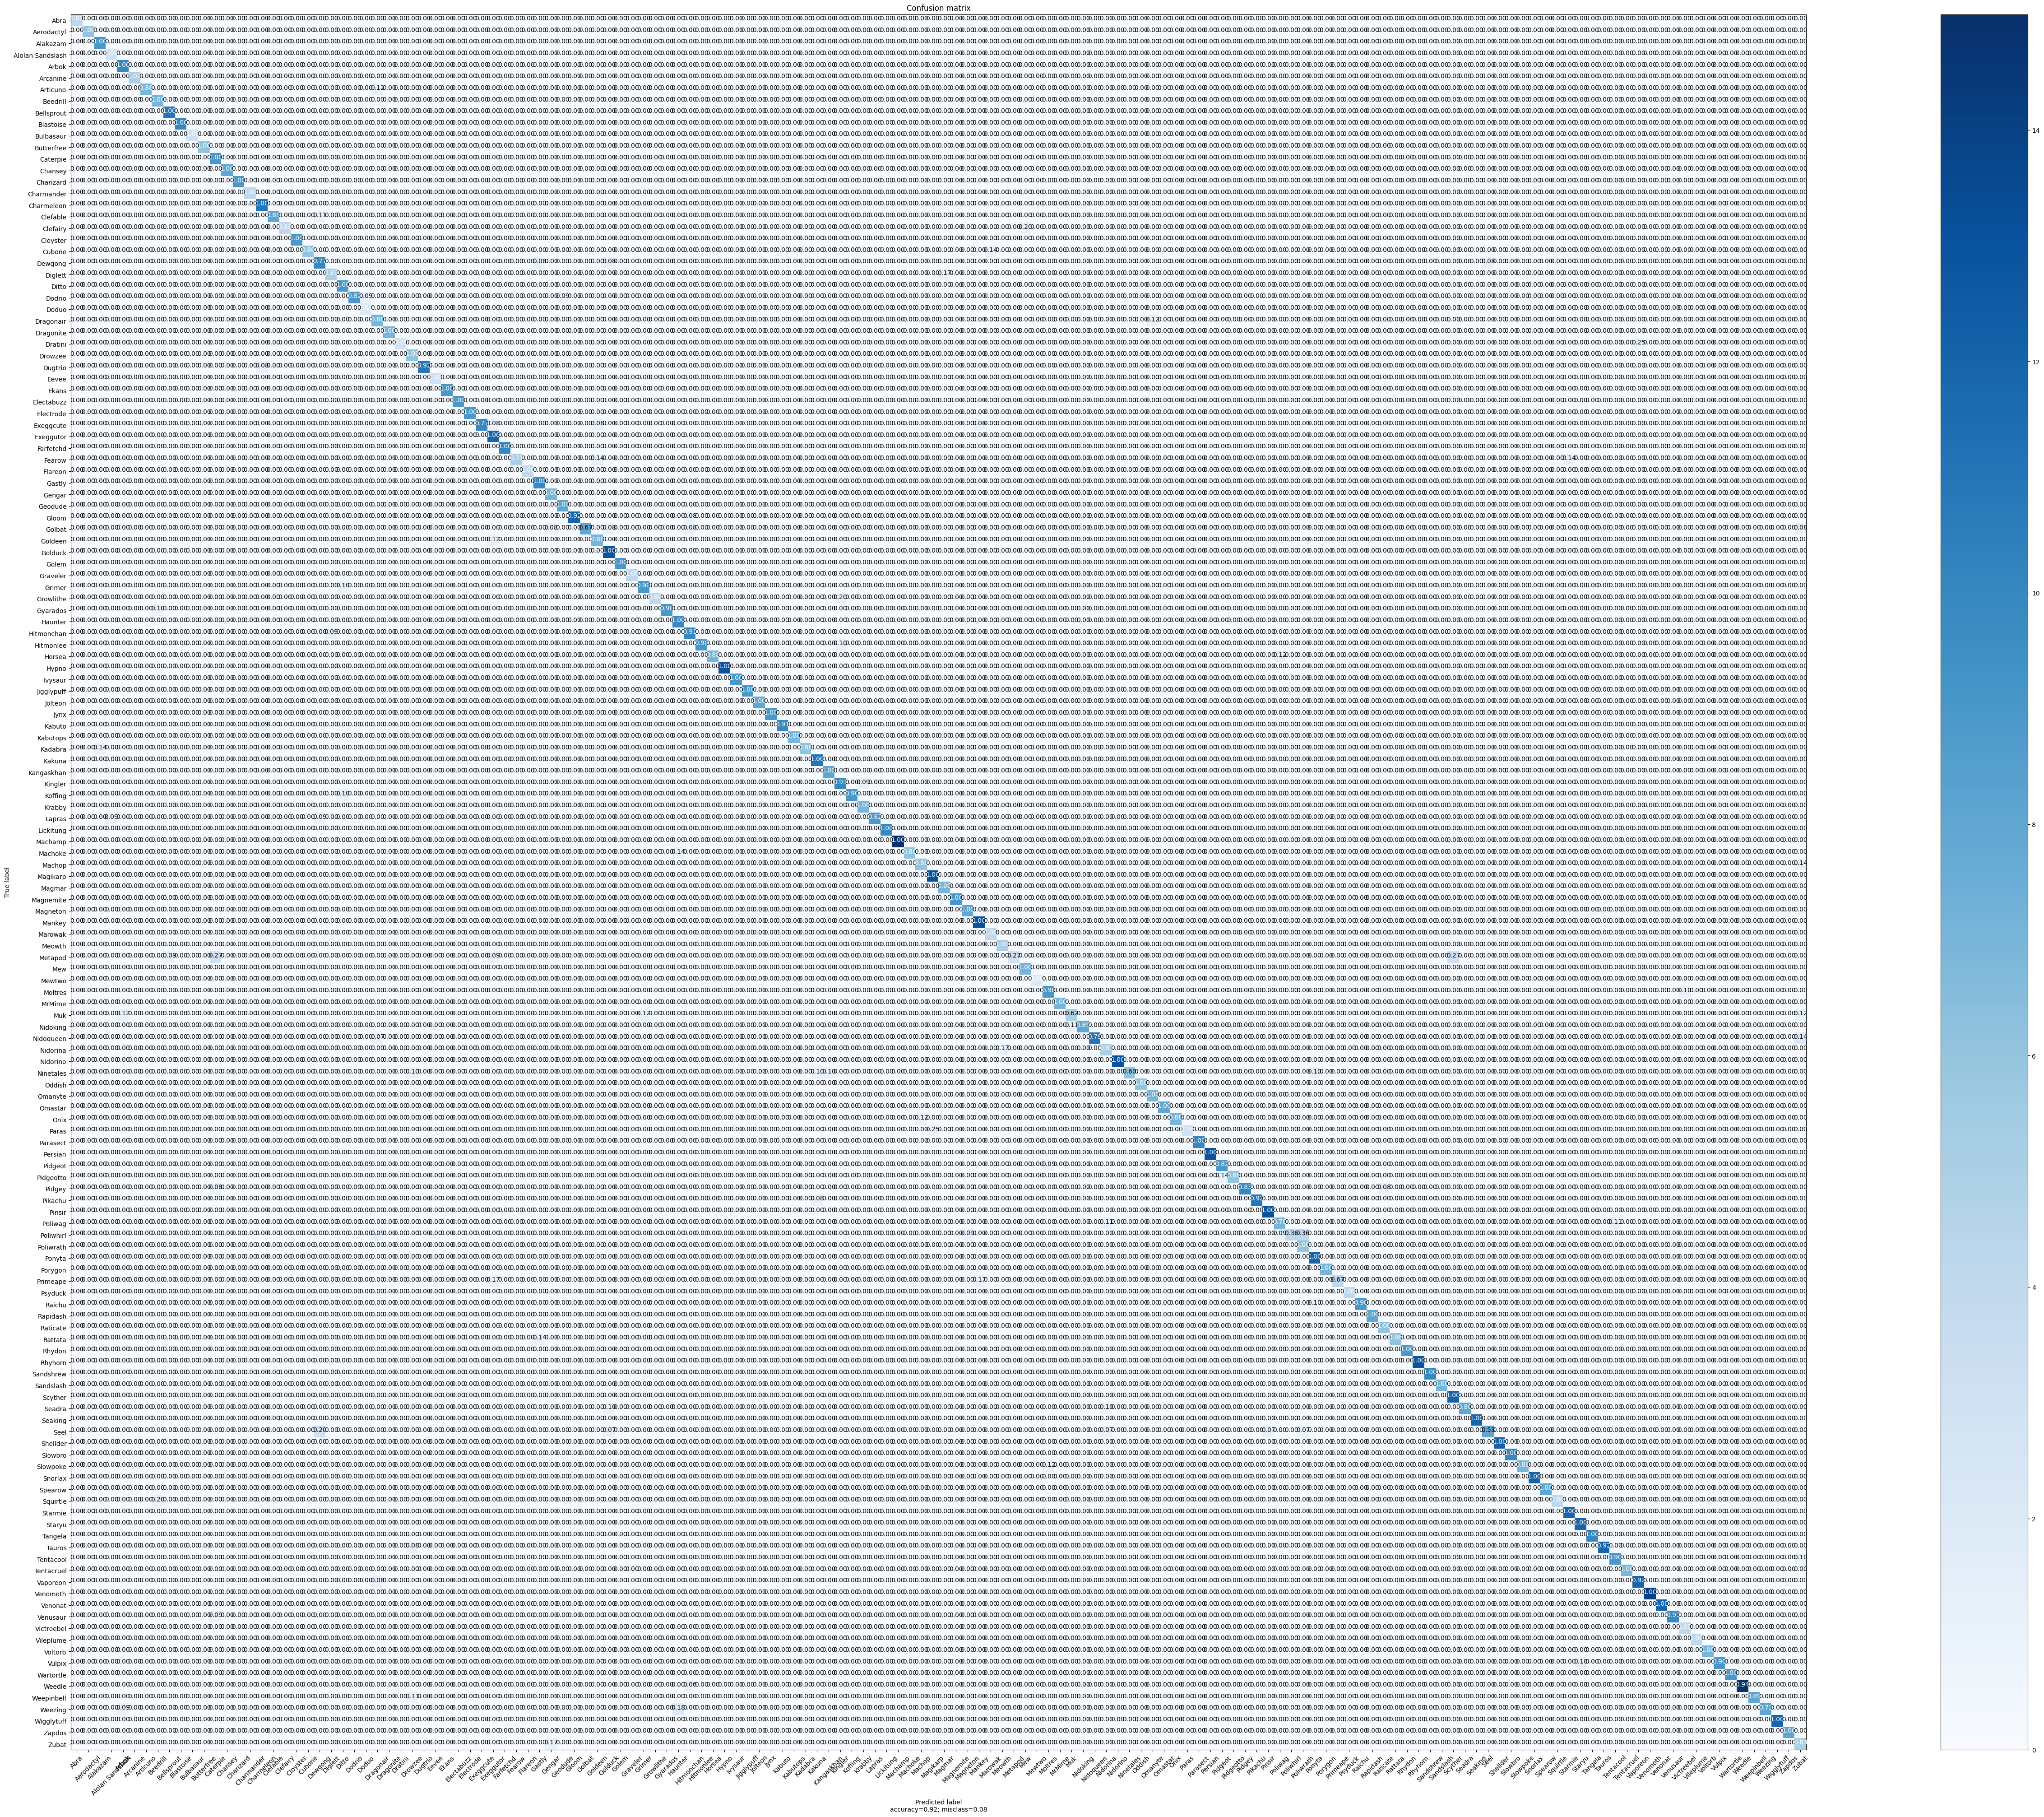

In [ ]:
plot_confusion_matrix(cm, tuple(classes.values()), font_size=10)

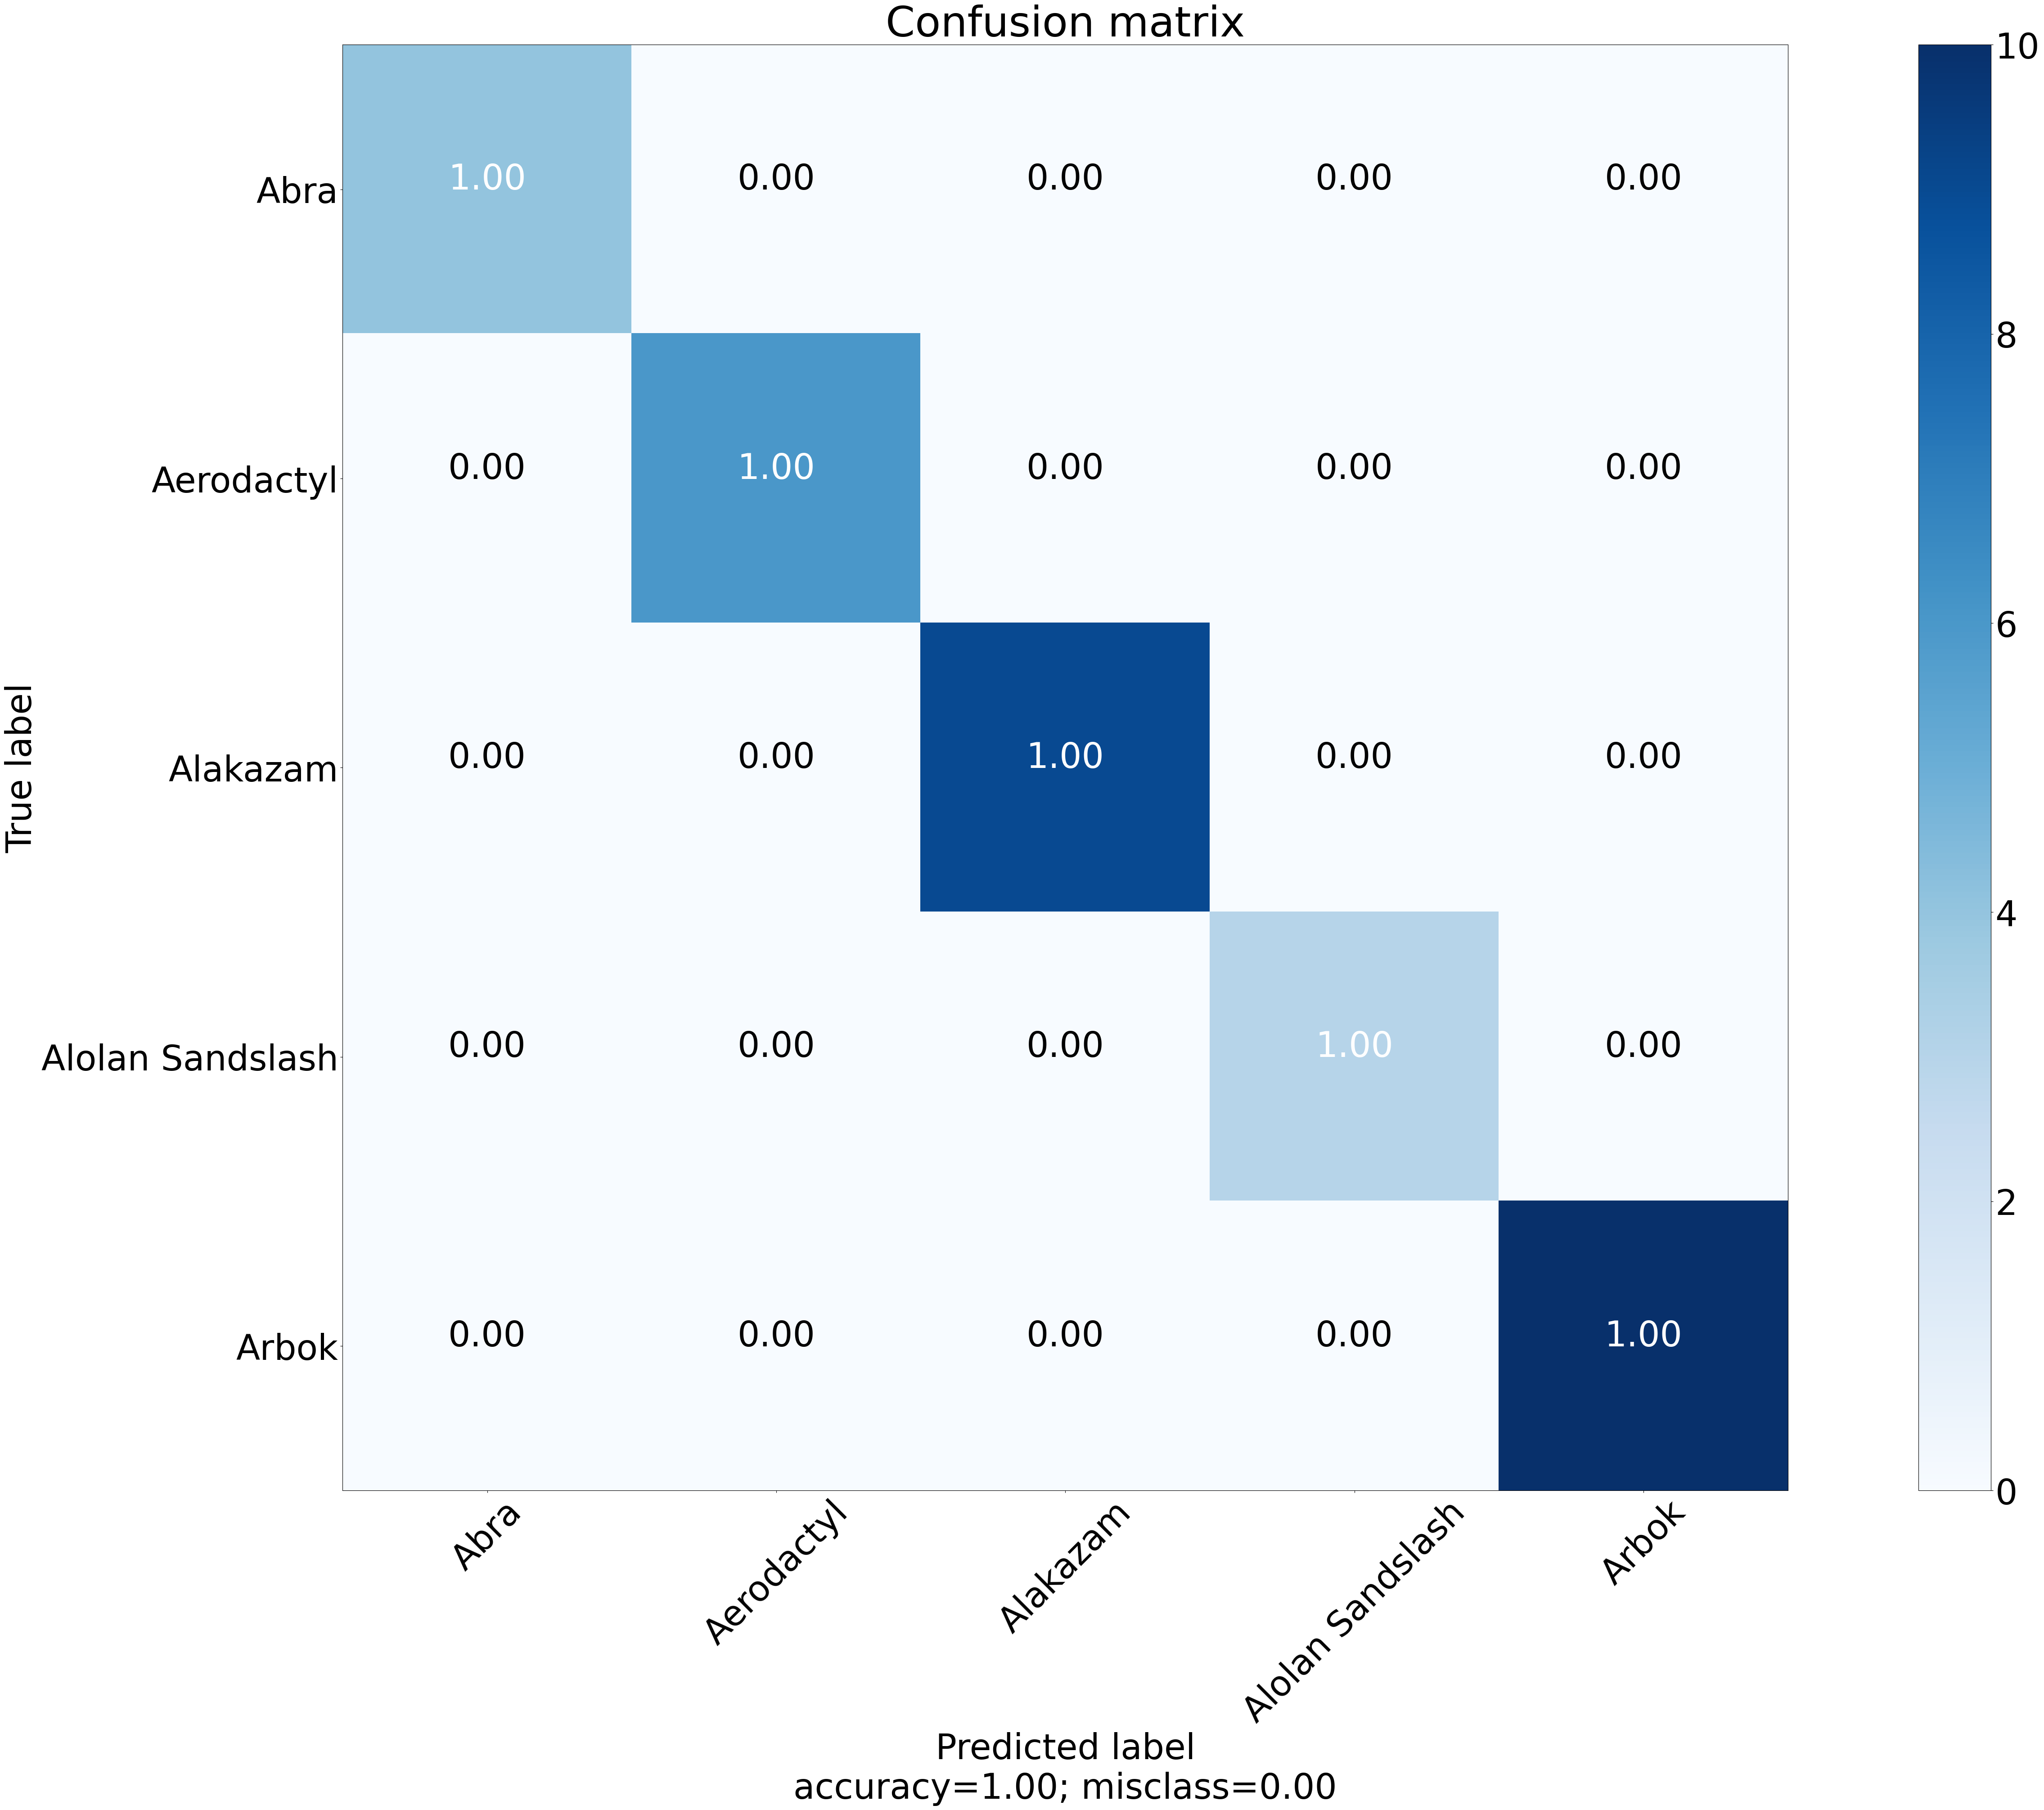

In [ ]:
plot_confusion_matrix(cm[:5,:5], tuple(classes.values())[:5], font_size=56)